In [1]:
import numpy as np
import matplotlib as plt 
import pandas as pd
import seaborn as sns

https://www.kaggle.com/c/ghouls-goblins-and-ghosts-boo/data
Data fields

* **id** - id of the creature
* **bone_length** - average length of bone in the creature, normalized between 0 and 1
* **rotting_flesh** - percentage of rotting flesh in the creature
* **hair_length** - average hair length, normalized between 0 and 1
* **has_soul** - percentage of soul in the creature
* **color** - dominant color of the creature: 'white','black','clear','blue','green','blood'
* type - target variable: 'Ghost', 'Goblin', and 'Ghoul'

In [2]:
train_data = pd.read_csv("train.csv", index_col="id")
test_data = pd.read_csv("test.csv", index_col="id")

print("Train data shape {} ", train_data.shape)
print("Test data shape {}", test_data.shape)

dataset = train_data.append(test_data)

Train data shape {}  (371, 6)
Test data shape {} (529, 5)


In [3]:
dataset.head(5)

,bone_length,color,hair_length,has_soul,rotting_flesh,type
id,,,,,,
0,0.354512,clear,0.465761,0.781142,0.350839,Ghoul
1,0.575560,green,0.531401,0.439899,0.425868,Goblin
2,0.467875,black,0.811616,0.791225,0.354330,Ghoul
4,0.776652,black,0.636766,0.884464,0.508723,Ghoul
5,0.566117,green,0.418594,0.636438,0.875862,Ghost


In [4]:
dataset.isnull().sum()

bone_length        0
color              0
hair_length        0
has_soul           0
rotting_flesh      0
type             529
dtype: int64

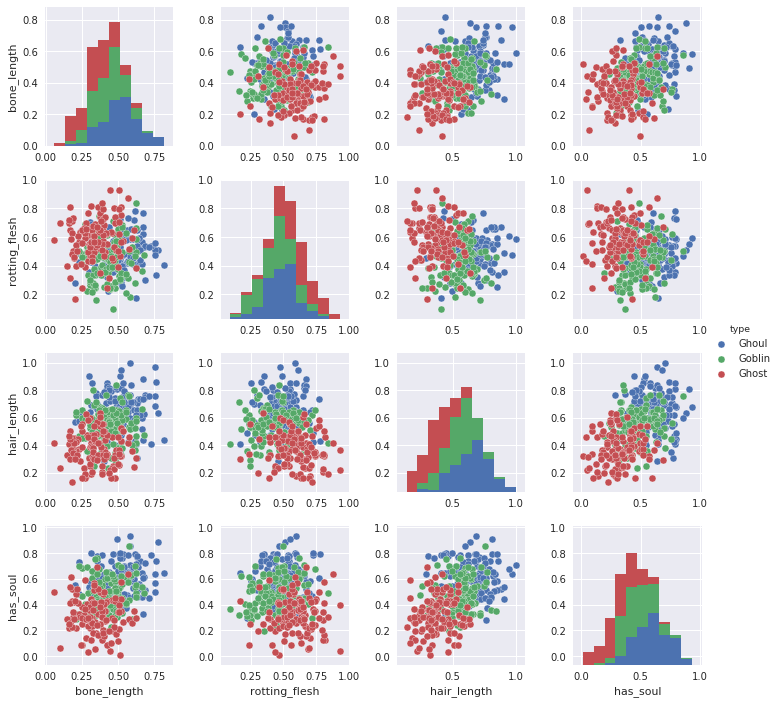

In [5]:
%matplotlib inline

sns.set()
sns.pairplot(train_data[["bone_length", "rotting_flesh", "hair_length", "has_soul", "type"]], hue="type")

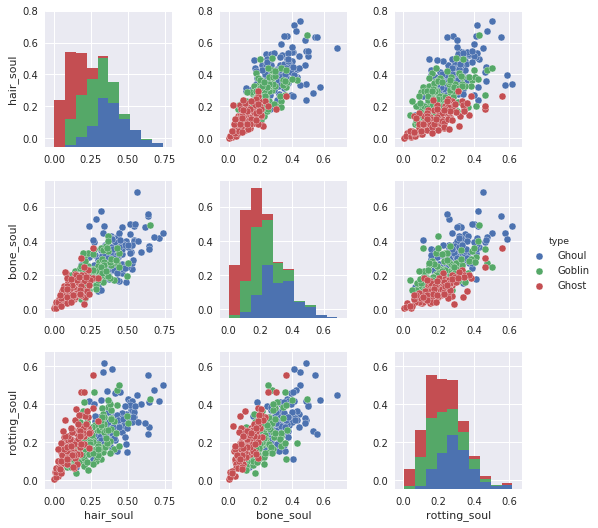

In [6]:
# lets create new train data with sth * has_soul
# видях го в един кернел и изглежда логично тъй като has_soul е вероятност


def pretify(data):
    data["hair_soul"] = data.apply(lambda row: row["hair_length"]*row["has_soul"],axis=1)
    data["bone_soul"] = data.apply(lambda row: row["bone_length"]*row["has_soul"],axis=1)
    data["rotting_soul"] = data.apply(lambda row: row["rotting_flesh"]*row["has_soul"],axis=1)
    return data


train_data = pretify(train_data)

%matplotlib inline

sns.set()
sns.pairplot(train_data[["hair_soul", "bone_soul", "rotting_soul", "type"]], hue="type")


Общо взето надолу правя енкодинг + грид сърч

In [17]:
categorical_columns = ["color"]
# numeric_columns = ["bone_length", "hair_length", "has_soul"]  # SVC with mean 0.692722371967655 
numeric_columns = ["bone_length", "hair_length", "has_soul", "rotting_flesh", "hair_soul", "bone_soul", "rotting_soul"] # SVC with mean 0.7304582210242587
numeric_columns = ["bone_length", "hair_length", "has_soul", "rotting_flesh","bone_soul"] # SVC with mean 0.7466307277628033, #0.73 score on kaggle
# numeric_columns = ["bone_length", "hair_length", "has_soul", "rotting_flesh", "rotting_soul"] # SVC with mean 0.738544474393531

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encoders = {col: LabelEncoder().fit(dataset[col]) for col in categorical_columns}

def encode_categorical(data, columns, encoders):
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

encoded = encode_categorical(dataset, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(encoded)



In [18]:
from sklearn.model_selection import train_test_split

#train_X , test_X, train_y, test_y = train_test_split(train_data.drop("type", axis=1), train_data["type"], random_state=26)

#print(test_y.value_counts()/train_y.value_counts())

train_X = train_data[numeric_columns + categorical_columns]
train_y = train_data["type"]

print("Train set shape {}".format(train_X.shape))

train_X.head(5)


Train set shape (371, 6)


,bone_length,hair_length,has_soul,rotting_flesh,bone_soul,color
id,,,,,,
0,0.354512,0.465761,0.781142,0.350839,0.276924,clear
1,0.575560,0.531401,0.439899,0.425868,0.253188,green
2,0.467875,0.811616,0.791225,0.354330,0.370195,black
4,0.776652,0.636766,0.884464,0.508723,0.686921,black
5,0.566117,0.418594,0.636438,0.875862,0.360298,green


In [19]:
one_hot_X_train = one_hot_encoder.transform(encode_categorical(train_X[categorical_columns], categorical_columns, encoders))
train_X = np.concatenate([train_X[numeric_columns], one_hot_X_train.toarray()], axis=1);


In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

clf = []

clf.append( ("Logistic", LogisticRegression()) )
clf.append( ("RandomForest", RandomForestClassifier()) )
clf.append( ("SVC", SVC()) )
clf.append( ("LinearSVC", LinearSVC()))

params = {
    "Logistic": [{"C": [0.1, 1, 10, 50, 100, 200]}],
    "SVC": [ {"C": [0.1, 1, 10, 100, 1000], "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000], "gamma": [0.001, 0.0001], "kernel": ["rbf"]}
           ],
    "LinearSVC":[
        {"C":[1, 10, 100, 1000], "random_state": [26]}
    ],
    "RandomForest": [{"random_state": [None, 0, 26], "n_estimators": [5, 10, 20, 50, 100], "max_depth":[None, 10, 15, 20]}]
}

for model_name, model in clf:
    grid_search =  GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs = -1)
    grid_search.fit(train_X, train_y)
    
    print("{} with mean {} ".format(model_name, grid_search.best_score_))
    print("Best estimator {}".format(grid_search.best_params_ ))
    

Logistic with mean 0.7277628032345014 
Best estimator {'C': 10}
RandomForest with mean 0.7250673854447439 
Best estimator {'random_state': 26, 'max_depth': 10, 'n_estimators': 100}
SVC with mean 0.7466307277628033 
Best estimator {'kernel': 'linear', 'C': 100}
LinearSVC with mean 0.7250673854447439 
Best estimator {'C': 1, 'random_state': 26}


In [33]:
test_data = pretify(test_data)
one_hot_X_submission = one_hot_encoder.transform(encode_categorical(test_data[categorical_columns], categorical_columns, encoders))
submission_X = np.concatenate([test_data[numeric_columns], one_hot_X_submission.toarray()], axis=1);

logistic = LogisticRegression(C=50)
random_f = RandomForestClassifier(random_state=26, n_estimators=50, max_depth=10)
svc = SVC(C=100, kernel="linear")
linear_svc = LinearSVC(C=100, random_state=26)

from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators= [("logistic", logistic), ("random_f", random_f), ("svc", svc), ("linearSVC", linear_svc)]) # weights=[1,1,2] even worse

score = cross_val_score(voting, train_X, train_y, cv=20)
print("Voting score on cross val {}".format(score.mean()))

# voting.fit(train_X, train_y)
# logistic.fit(train_X, train_y)
# random_f.fit(train_X, train_y)
# svc.fit(train_X, train_y)

test_X1 , test_X2, test_y1, test_y2 = train_test_split(train_data.drop("type", axis=1), train_data["type"], random_state=26)
test_X1 = pretify(test_X1)
test_X2 = pretify(test_X2)

one_hot_X1_train = one_hot_encoder.transform(encode_categorical(test_X1[categorical_columns], categorical_columns, encoders))
test_X1 = np.concatenate([test_X1[numeric_columns], one_hot_X1_train.toarray()], axis=1);

one_hot_X2_train = one_hot_encoder.transform(encode_categorical(test_X2[categorical_columns], categorical_columns, encoders))
test_X2 = np.concatenate([test_X2[numeric_columns], one_hot_X2_train.toarray()], axis=1);

clf_with_params = []
clf_with_params.append( ("Logistic", logistic) )
clf_with_params.append( ("RandomForest", random_f) )
clf_with_params.append( ("SVC", svc) )
clf_with_params.append( ("LinearSVC", linear_svc))

for model_name, model in clf_with_params:
    model.fit(train_X, train_y)
    print("Model {} scores: {}, {}".format(model_name, model.score(test_X1, test_y1), model.score(test_X2, test_y2)))


Voting score on cross val 0.726064671482628
Model Logistic scores: 0.7553956834532374, 0.7956989247311828
Model RandomForest scores: 1.0, 1.0
Model SVC scores: 0.7733812949640287, 0.7956989247311828
Model LinearSVC scores: 0.7589928057553957, 0.7849462365591398


In [34]:
#prediction = logistic.predict(submission_X)
#prediction = random_f.predict(submission_X)
#prediction = svc.predict(submission_X) # 74.102
#prediction = voting.predict(submission_X) # 0.72967

df = pd.DataFrame(data={"type": prediction}, index=test_data.index)
df.to_csv("submission.csv")